In [1]:
!ls ../input/resnet200d320-640-fold0-end/resnet200d_320_fold0_end.pth

../input/resnet200d320-640-fold0-end/resnet200d_320_fold0_end.pth


In [2]:
!cp ../input/resnet200d320-640-fold0-end/resnet200d_320_fold0_end.pth  ./resnet200d_320_resffn_fold0_end.pth

In [3]:
import sys
sys.path.append ('../input/pytorch-images-seresnet')

import os
import gc
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
import math

import fastai
from   fastai.callback.mixup import MixUp, CutMix
from   fastai.callback import *
from   fastai.callback.all import *
from   fastai.callback.training import GradientClip
from   fastai.callback.all import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateau 
from   fastai.data.core import *
from   fastai.data.load import *
from   fastai.learner import Learner
from   fastai.metrics import *
from   fastai.optimizer import OptimWrapper 
from   fastai.losses import LabelSmoothingCrossEntropy

# from   warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold

import timm
import albumentations as A
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings ("ignore")

In [4]:
class CFG:
    device       = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
    num_workers  = 4
    model_name   = 'resnet200d_320_resffn' # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    size         = 640  # [64, 128, 224, 384, 512, 640, 720]
    train        = True
    freeze       = True     # this is updated during training   
    epochs       = 1 
    epochsNx     = 14
    criterion    = 'BCEWithLogitsLoss'    # ['CrossEntropyLoss', 'BCEWithLogitsLoss', 'SmoothBCEwithLogits']
    batch_size   = 116
    weight_decay = 1e-6
    max_grad_norm= 1
    seed         = 42
    target_size  = -1    # init below
    n_fold       = 20
    train_fold   = [0] #, 1, 2, 3, 4]
    # infer_fold = [0, 1, 2, 3, 4]
    img_ext      = '.jpg'
    img_col      = "StudyInstanceUID"
    label_cols   = [
                    'ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                    'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                    'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                    'Swan Ganz Catheter Present'
    ]
    model_infer_path_prefix = "." # "../input/ranzcr-chest-xray-pretrainer" 
    model_train_path_prefix = "."
    train_path   = '../input/ranzcr-clip-catheter-line-classification/train'
    train_csv    = '../input/ranzcr-clip-catheter-line-classification/train.csv'
    test_path    = '../input/ranzcr-clip-catheter-line-classification/test'
    test_csv     = '../input/ranzcr-clip-catheter-line-classification/sample_submission.csv'
    output_dir   = 'Output/'
    
    freeze_epo   = 0.5       # float: these many epochs are with frozen model at the beginning
    print_every  = 100
    prev_target_size = 14
    tta          = 3 
    min_unfreez_layer = 2 # allowed to unfreeze layers 11 to 5 only and not less than 5
    smoothing    = 0.1
    freeze_epo   = 1 # after these epochs, gradually unfreeze top layers
    gradual_unfreez_epo = 7
    IMG_MEAN     = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD      = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]            
    
CFG.target_size = len (CFG.label_cols)

In [5]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [6]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

# Augmentation Dataset

In [7]:
# NOTE: We don't normalize here since it all gets dark
# if advprop:           # for models using advprop pretrained weights
#     normalize = transforms.Lambda(lambda img: img * 2.0 - 1.0)
# else:
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
Aug_Norm = A.Normalize ()

train_transforms = A.Compose ([
    A.Resize (CFG.size, CFG.size),
    A.HorizontalFlip (p=0.5),
    A.HueSaturationValue (hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast (brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
    A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
    A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.CoarseDropout(p=0.5),
    Aug_Norm,
    ToTensorV2 (p=1.0),
])
valid_transforms = A.Compose ([
    A.Resize (CFG.size, CFG.size),
    Aug_Norm,
    ToTensorV2 (p=1.0),
])

def get_transforms (data='train'):
    
    if 'train' in data:
        return train_transforms
    elif 'valid' in data:
        return valid_transforms
    else:
        return valid_transforms

In [8]:
class ImgDataset (Datasets):
    
    def __init__(self, df, img_file_colname=CFG.img_col, label_cols=CFG.label_cols, 
                 transform=get_transforms(), img_dir=CFG.train_path, img_ext=CFG.img_ext):
        
        super (ImgDataset, self).__init__(df.reset_index(drop=True), tfms=None, n_inp=1)
        self.img_ext          = CFG.img_ext
        self.img_dir          = img_dir
        self.label_cols       = label_cols
        self.img_file_colname = img_file_colname
        self.transform        = transform
        return
    
    def __len__(self):
        return self.items.shape[0]    
    
    def __getitem__(self, idx):
        
        file_name = self.items[self.img_file_colname][idx].replace (self.img_ext, '') + self.img_ext
        file_path = f'{self.img_dir}/{file_name}'
        image     = cv2.imread (file_path)
        image     = cv2.cvtColor (image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform (image=image)['image'].float ()
        else:
            image = ToTensorV2 ()(image = image)["image"].float ()
        
        if len (self.label_cols) > 0:
            label = torch.tensor (self.items.loc[idx, self.label_cols]).float () # long ()
            return image, label
        return image

In [9]:
def getFolds ():
    
    train_folds_df = pd.read_csv (CFG.train_csv)
    label = train_folds_df[CFG.label_cols]
    if len (CFG.label_cols) > 1:
        label = train_folds_df[CFG.label_cols[0]]
        
    skf = StratifiedKFold (n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate (skf.split (train_folds_df, label)):
        train_folds_df.loc[val_index, 'fold'] = int (n)
    train_folds_df['fold'] = train_folds_df['fold'].astype (int)
    # print (train_folds_df.groupby (['fold', label]).size ())
        
    return train_folds_df

55

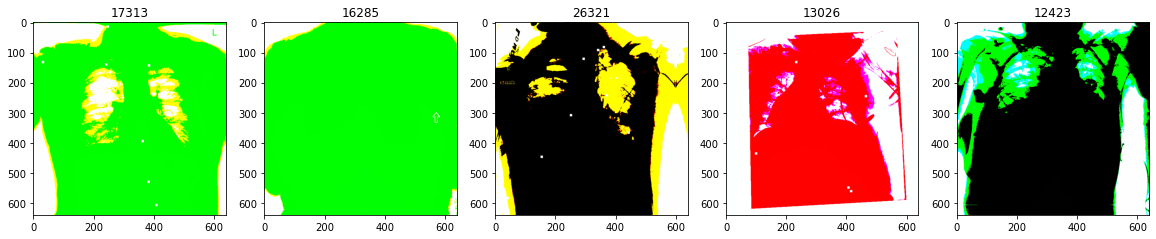

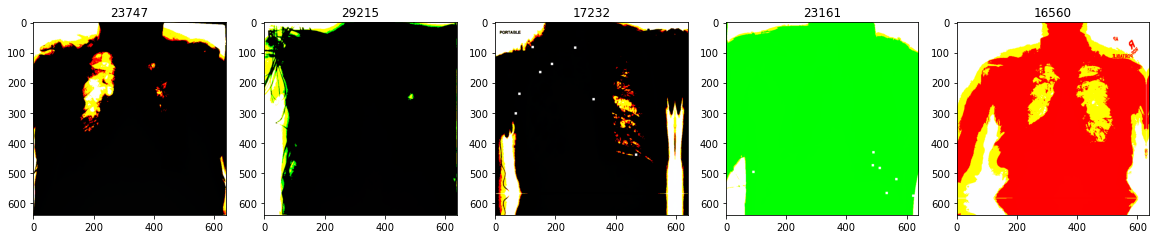

In [10]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,5)
        for p in range (5):
            idx = np.random.randint (0, len (dataset_show))
            img, label = dataset_show[idx]                         # ;print (img.size()) ;print (label)
            img = img.byte ()
            axarr[p].imshow (img.permute(1, 2, 0))
            axarr[p].set_title (idx)
    return

TR_DATASET = ImgDataset (getFolds ())
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

> # Loss Functions

In [11]:
# this works for only 1 label, not multi-label target.
class SmoothBCEwLogits (_WeightedLoss):
    
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [12]:
def get_criterion (class_wt):
    
    if CFG.criterion=='CrossEntropyLoss':
        criterion = LabelSmoothingCrossEntropy ()
    elif CFG.criterion=='SmoothBCEwithLogits':
        criterion = SmoothBCEwLogits (smoothing=CFG.smoothing)
    elif CFG.criterion=='BCEWithLogitsLoss':
        criterion =  nn.BCEWithLogitsLoss (pos_weight=class_wt)
    return criterion

In [13]:
class Ren_ffn (nn.Module):
    
    def __init__(self, inputSize, hidden_size, outputSize, dropout_rate=0.2):
        
        super (Ren_ffn, self).__init__()
        self.batch_norm0 = nn.BatchNorm1d (inputSize)
        self.dropout0 = nn.Dropout (dropout_rate)

        self.dense1 = nn.Linear (inputSize, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d (hidden_size)
        self.dropout1 = nn.Dropout (dropout_rate)

        self.dense2 = nn.Linear (hidden_size+inputSize, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d (hidden_size)
        self.dropout2 = nn.Dropout (dropout_rate)

        self.dense3 = nn.Linear (hidden_size+hidden_size, hidden_size)
        self.batch_norm3 = nn.BatchNorm1d (hidden_size)
        self.dropout3 = nn.Dropout (dropout_rate)

        self.dense4 = nn.Linear (hidden_size+hidden_size, hidden_size)
        self.batch_norm4 = nn.BatchNorm1d (hidden_size)
        self.dropout4 = nn.Dropout (dropout_rate)

        self.dense5 = nn.Linear (hidden_size+hidden_size, outputSize)

        # self.Relu = nn.ReLU (inplace=True)
        # self.PReLU = nn.PReLU ()
        # self.GeLU = nn.GELU ()
        # self.RReLU = nn.RReLU ()
        self.LeakyReLU = nn.LeakyReLU (negative_slope=0.01, inplace=True)
        return

    def forward (self, x):
        x = self.batch_norm0 (x)
        x = self.dropout0 (x)

        x1 = self.dense1 (x)
        x1 = self.batch_norm1 (x1)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x1 = self.LeakyReLU (x1)
        x1 = self.dropout1 (x1)

        x = torch.cat ([x, x1], 1)

        x2 = self.dense2 (x)
        x2 = self.batch_norm2 (x2)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x2 = self.LeakyReLU (x2)
        x2 = self.dropout2 (x2)

        x = torch.cat ([x1, x2], 1)

        x3 = self.dense3 (x)
        x3 = self.batch_norm3 (x3)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x3 = self.LeakyReLU (x3)
        x3 = self.dropout3 (x3)
        
        x = torch.cat ([x2, x3], 1)
        
        x4 = self.dense4 (x)
        x4 = self.batch_norm4 (x4)
        # x = F.relu(x)
        # x = self.PReLU(x)
        x4 = self.LeakyReLU (x4)
        x4 = self.dropout4 (x4)
        
        x = torch.cat ([x3, x4], 1)
        x = self.dense5 (x)
        
        return x

In [14]:
N_FEATURES = 1

class ResNet200D (nn.Module):
    
    def __init__(self, model_name='resnet200d_320'):
        
        super().__init__()
        self.model = timm.create_model (model_name, pretrained=False)
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity ()
        self.model.fc = nn.Identity ()
        self.pooling = nn.AdaptiveAvgPool2d (1)
        self.fc = nn.Linear (n_features, 11)
        global N_FEATURES
        N_FEATURES = n_features
        return
    
    def forward(self, x):
        
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters ():
            param.requires_grad = False

        for param in self.fc.parameters ():
            param.requires_grad = True
        return
    
    def unfreeze (self):
        # Unfreeze all layers
        for param in self.model.parameters ():
            param.requires_grad = True
        for param in self.fc.parameters ():
            param.requires_grad = True
        return
    
class CustomResNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear (n_features, CFG.target_size)
        return
    
    def forward(self, x):
        x = self.model (x)
        return x
    
    def freeze (self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
class CustomResNext(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.fc.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
            

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model (CFG.model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
    
    
class CustomDeiT(nn.Module):
    def __init__(self, model_name=CFG.model_name, pretrained=False):
        super().__init__()
        self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

    
class CustomViT(nn.Module):
    
    def __init__(self, model_name=CFG.model_name, pretrained=False, 
                ): # min_unfreez_layer=CFG.min_unfreez_layer, max_layer_no=CFG.max_layer_no):
        
        super().__init__()
        self.model      = timm.create_model(model_name, pretrained=pretrained)
        n_features      = self.model.head.in_features
        self.model.head = nn.Linear(n_features, CFG.target_size)
        # self.min_unfreez_layer = min_unfreez_layer
        # self.max_layer_no      = max_layer_no
        return

    def forward(self, x):
        x = self.model(x)
        return x
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.head.parameters():
            param.requires_grad = True
        return
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True
        return
    
    # def unfreeze_layer (self, layer_no=11):
    #     # unfreeze a particular layer
    #     if layer_no >= self.min_unfreez_layer and layer_no <= self.max_layer_no:
    #         for param in self.model.blocks[layer_no].parameters ():
    #             param.requires_grad = False
    #     return

In [15]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates (subplots)
def plot_metrics (self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil (n / ncols))
    elif ncols is None: ncols = int(np.ceil (n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots (nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate (axs.flatten())][:n]
    for i, (name, ax) in enumerate (zip (names, [axs[0]] + axs)):
        ax.plot (metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title (name if i > 1 else 'losses')
        ax.legend (loc='best')
    plt.show ()

In [16]:
@delegates (torch.optim.AdamW.__init__)
def pytorch_AdamW (param_groups, **kwargs):
    return OptimWrapper (torch.optim.AdamW ([{'params': ps, **kwargs} for ps in param_groups]))

In [17]:
class UnfreezeCallback (Callback):
    
    def __init__(self, freeze_epo=CFG.freeze_epo):
        super().__init__()
        self.freeze_epo   = freeze_epo
        return
        
    def before_epoch (self): 
        if self.epoch == self.freeze_epo:
            print ('UnfreezeCallback : unfreezing the model')
            self.learn.model.unfreeze ()

In [18]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))['model']
        # print (state_dict)
        model.load_state_dict (state_dict) # (torch.load (model_path, map_location=torch.device ('cpu')), strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [19]:
def getModel (fold, isTrain=True):
    
    model = None
    if 'resnet200d_320' in CFG.model_name:
        model = ResNet200D ()
    elif 'deit_' in CFG.model_name:
        model = CustomDeiT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'vit_' in CFG.model_name:
        model = CustomViT (model_name=CFG.model_name, pretrained=isTrain)
    elif 'resnext' in CFG.model_name:
        model = CustomResNext (CFG.model_name, pretrained=isTrain)
    elif 'resnet' in CFG.model_name:
        model = CustomResNet (CFG.model_name, pretrained=False)  #TODO: pretrained=isTrain
    elif 'efficientnet' in CFG.model_name:
        model = CustomEfficientNet (CFG.model_name, pretrained=isTrain)  
    if isTrain:
        
        # TODO: _infer_ to _train_,   _end to _maxacc
        model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_end.pth'        
        # if os.path.exists (model_path):
        print ("loading", model_path)
        load_state (model_path, model)
        model.fc = Ren_ffn (N_FEATURES, N_FEATURES, 11)
    else:
        
        # TODO: change CFG.model_train_path_prefix to CFG.model_infer_path_prefix
        model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        load_state (model_path, model)
        
    if CFG.freeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    return model

In [20]:
def fit_epochs (fold, callbacks, learn, max_acc, epochNx, start_lr=1e-6, end_lr=5e-5, lr_scaler=1, model=None):
    
    if model is None:
        model   = getModel (fold, isTrain=True).float().to (CFG.device)
    learn.model = model
    
    # lr_min    = 0.00002
    lr_min, _   = learn.lr_find (start_lr=start_lr, end_lr=end_lr, num_it=100) 
    lr_min      = lr_min * lr_scaler
    print ('lr_min =', lr_min)
    lr          = lr_min
    learn.fit_one_cycle (CFG.epochs, lr, wd=CFG.weight_decay, cbs=callbacks)
    # learn.recorder.plot_metrics ()
    # learn.recorder.plot_lr ()        
    acc = learn.recorder.metrics[0].value #.numpy ()
    if acc > max_acc:
        max_acc = acc
        print ("Saving Max-Acc model", max_acc)
        learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_maxacc')
    learn.save (f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_eNx{epochNx+1}')
    return max_acc

In [21]:
def train_fold_loop (fold, train_df=getFolds ()):

    print (f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = train_df[train_df['fold'] != fold].index
    val_idx = train_df[train_df['fold'] == fold].index
    train_folds_df = train_df.loc[trn_idx].reset_index (drop=True)
    valid_folds_df = train_df.loc[val_idx].reset_index (drop=True)
    class_wt       = train_df[CFG.label_cols].sum (axis=0)
    class_wt       = torch.tensor (np.sum (np.array (class_wt.values)) / np.array (class_wt.values))  ;print ('class_wt =', class_wt)
    class_wt       = class_wt.to (CFG.device)
    del train_df; gc.collect ()
    
    loss_func      = get_criterion (class_wt=class_wt)
    model          = getModel (fold, isTrain=True)
    model          = model.float().to (CFG.device)
    modelfile      = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}'
    train_dataset  = ImgDataset (train_folds_df, transform=get_transforms ('train'))
    valid_dataset  = ImgDataset (valid_folds_df, transform=get_transforms ('valid'))
    train_datlder  = DataLoader (train_dataset, batch_size=CFG.batch_size, device=CFG.device)
    valid_datlder  = DataLoader (valid_dataset, batch_size=CFG.batch_size, device=CFG.device)
    dls            = DataLoaders (train_datlder, valid_datlder, device=CFG.device)
    metrics        = [accuracy, error_rate]    # fbeta, auc_roc_score 
    if len (CFG.label_cols) > 1:
        metrics    = [F1ScoreMulti (), accuracy_multi]
    learn          = Learner (dls, model, loss_func=loss_func, model_dir=f'{CFG.model_train_path_prefix}',
                     opt_func=partial (pytorch_AdamW, lr=0.007, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
                     metrics=metrics)
    learn.recorder.train_metrics = True
    print (learn.summary ())
    
    # initially cfg.freeze=True, but only for the 1st time, at end it is =False to train the deep layers
    max_acc = 0
    for i in range (CFG.epochsNx):
        
        valid_scores = learn.validate (dl=valid_datlder)
        print (f'fold-{fold} epochsNx-{i} valid-scores:-')
        print (valid_scores)
        
        lr_scaler = 2
        start_lr, end_lr = 5e-5, 5e-4
        if i >= 5:
            lr_scaler = 1
            start_lr, end_lr = 1e-5, 1e-4
        elif i >= 10:
            lr_scaler = 0.5
            start_lr, end_lr = 5e-6, 5e-5
            
        callbacks = [
            # monitor: train_loss  valid_loss   train_f1_score  valid_f1_score   valid_accuracy_multi
            # EarlyStoppingCallback (monitor='train_f1_score', min_delta=0.001, patience=3), # useless now
            # SaveModelCallback     (monitor='train_f1_score', fname=modelfile),             # useless now
            ReduceLROnPlateau     (monitor='train_f1_score', min_delta=0.001, factor=2.0, min_lr=1e-8, patience=1),
            GradientClip (CFG.max_grad_norm),
        ]
        # if i==0:
        #     callbacks.append (UnfreezeCallback ())
            
        # For fine tuning don't pass the model
        # model = model.to ('cpu'); del model; gc.collect ()        
        # max_acc = fit_epochs (fold, callbacks, learn, max_acc, start_lr, end_lr)
        
        # For pre-training pass the model
        max_acc = fit_epochs (fold, callbacks, learn, max_acc, i, start_lr, end_lr, lr_scaler, model)
        
        # if i==0:
        #     CFG.freeze = False
        #     print ("Unfreezing the model")
        #     model.unfreeze ()
        gc.collect ()
    valid_scores = learn.validate (dl=valid_datlder)
    print (f'fold-{fold} epochsNx-end valid-scores:-')
    print (valid_scores)
    return valid_scores

In [22]:
def train_main ():
    
    if CFG.train:
        
        valid_scores = []
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                valid_scores_fold = train_fold_loop (fold)
                valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores.append (valid_scores_fold)
                
        print (f"========== CV ==========")
        valid_scores = np.vstack (valid_scores)
        valid_scores = np.mean (valid_scores, axis=0)
        print ("CV Scores =", valid_scores)

In [23]:
!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
# model_names = timm.list_models (pretrained=True)
# model_names = timm.list_models ('*resnet*', pretrained=True)
# pprint (model_names)

LOGGER = init_logger ()
seed_everything (seed=CFG.seed)
train_main ()

========== fold: 0 training ==========
class_wt = tensor([640.7468,  44.4807,   6.9916, 181.4301,  95.6881,  18.4203,  10.5522,
         15.8432,   5.9833,   2.3738,  60.9867], dtype=torch.float64)
loading ./resnet200d_320_resffn_fold0_end.pth


ResNet200D (Input shape: 116)
Layer (type)         Output Shape         Param #    Trainable 
                     116 x 32 x 320 x 32 
Conv2d                                    864        False     
BatchNorm2d                               64         False     
ReLU                                                           
Conv2d                                    9216       False     
BatchNorm2d                               64         False     
ReLU                                                           
____________________________________________________________________________
                     116 x 64 x 320 x 32 
Conv2d                                    18432      False     
BatchNorm2d                               128        False     
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                              

fold-0 epochsNx-0 valid-scores:-
[1.7355027198791504, 0.14102466397889404, 0.47212323546409607]


RuntimeError: CUDA out of memory. Tried to allocate 2.83 GiB (GPU 0; 15.90 GiB total capacity; 8.64 GiB already allocated; 2.31 GiB free; 12.81 GiB reserved in total by PyTorch)

In [24]:
print ('Done !')

Done !
